In [1]:
import pyspark as ps
from pyspark.sql import SQLContext
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import CountVectorizer, Tokenizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
import time
import pandas as pd
import pymysql
spark = (
        ps.sql.SparkSession.builder 
        .master("justin") 
        .appName("chicago") 
        .getOrCreate()
        )

sc = spark.sparkContext

In [ ]:
df_sp = spark.read.csv('/home/justin/Downloads/bq-results-20190515-182310-9jmw514pxnfg.csv', header='true',
                       inferSchema='true')

In [3]:
df_pd = df_sp.select('unique_key','arrest','block','community_area','district','latitude','longitude').toPandas()

In [4]:
train = df_pd[df_pd.longitude.isnull()==False]
test = df_pd[df_pd.longitude.isnull()==True]

In [5]:
X_train = train[train.columns.difference(['arrest','longitude'])].block.values
y_train = train['longitude']

In [6]:
vect = TfidfVectorizer()
X_train_vect=vect.fit_transform(X_train)

In [7]:
model = SGDRegressor(loss="squared_loss", penalty='l2', random_state=101, max_iter=5)
params= {'penalty':['none','l2','l1'],
        'alpha':[5e-4,5e-2, .1]}
gs=GridSearchCV(estimator=model,
               param_grid=params,
               scoring='neg_mean_squared_error',
               n_jobs=1,
               cv=5,
               verbose=3)
start=time.time()
gs.fit(X_train_vect, y_train)
end=time.time()
print("Time it took {}".format(end-start))

In [ ]:
model = gs.best_estimator_
pipe = Pipeline([('vect',vect),('model',model)])
y_pred = pipe.predict(test.block.values)

In [9]:
for idx, val in enumerate(test.index):
    df_pd.iloc[val,5] = y_pred[idx] 

In [12]:
train_lat = df_pd[df_pd.latitude.isnull()==False]
test_lat = df_pd[df_pd.latitude.isnull()==True]

In [13]:
X_train_lat = train_lat[train_lat.columns.difference(['arrest','latitude'])].block.values
y_train_lat = train_lat['latitude']

In [14]:
vect_lat = TfidfVectorizer()
X_train_vect_lat=vect_lat.fit_transform(X_train_lat)

In [15]:
model = SGDRegressor(loss="squared_loss", penalty='l2', random_state=101, max_iter=5)
params= {'penalty':['none','l2','l1'],
        'alpha':[5e-4,5e-2, .1]}
gs=GridSearchCV(estimator=model,
               param_grid=params,
               scoring='neg_mean_squared_error',
               n_jobs=1,
               cv=5,
               verbose=3)
start=time.time()
gs.fit(X_train_vect_lat, y_train_lat)
end=time.time()
print("Time it took {}".format(end-start))

In [ ]:
model1 = gs.best_estimator_
pipe = Pipeline([('vect',vect_lat),('model',model1)])
y_pred = pipe.predict(test_lat.block.values)

In [17]:
for idx, val in enumerate(test_lat.index):
    df_pd.iloc[val,4] = y_pred[idx] 


In [18]:
df_pd.to_pickle("./chicago.pkl")

In [ ]:
unpickled_df = pd.read_pickle("./chicago.pkl")

In [8]:
unpickled_df = pd.concat([df_pd.unique_key, unpickled_df], axis=1, sort=False)

NameError: name 'df_pd' is not defined

In [8]:
unpickled_df = unpickled_df.rename(index=str, columns={'latitude':'Latitude1','longitude':'Longitude1','arrest':'arrest1'})

In [10]:
df_sp2 = spark.createDataFrame(unpickled_df)

In [11]:
df = df_sp.join(df_sp2,['unique_key'],"inner")

In [12]:
df.show(5,False)

+----------+-----------+-----------------------+-----------------------+----+------------+-------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-----------------------+------------+-------------+-----------------------------+------+-----------------------+--------------+--------+------------+-------------+
|unique_key|case_number|date                   |block                  |iucr|primary_type|description        |location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|updated_on             |latitude    |longitude    |location                     |arrest|block                  |community_area|district|Latitude1   |Longitude1   |
+----------+-----------+-----------------------+-----------------------+----+------------+-------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+---------

In [56]:
from pyspark.sql.functions import to_timestamp,year, month, dayofmonth, hour,when 
from pyspark.sql.functions import lit

df_sp_dt = df.withColumn('dt',to_timestamp(df_sp.date,'yyyy-MM-dd HH:mm:ss'))\
        .withColumn('Year',year(col("dt")))\
        .withColumn('Month',month(col("dt")))\
        .withColumn('Hour',hour(col("dt")))\
        .withColumn('Night?', when(col('Hour')>=17,1).otherwise(0))\
        .withColumn('Domestic1', when(col('domestic')=='false',0).otherwise(1))\
        .withColumn('Arrest1', when(col('arrest')==True,1).otherwise(0))
        

In [57]:
# df_sp_dt.rdd.saveAsPickleFile("./chicago1.pkl")

# pickleRdd = sc.pickleFile("./chicago1.pkl").collect()
# df2 = spark.createDataFrame(pickleRdd)
df_sp_dt.select('Arrest1')

DataFrame[Arrest1: int]

In [43]:
from pyspark.ml.feature import HashingTF,IDF, Tokenizer


In [44]:
from pyspark.ml.feature import OneHotEncoderEstimator,StringIndexer, VectorAssembler


In [58]:
df_pd2 = df_sp_dt.select('Arrest1','primary_type','fbi_code','month','Night?','Domestic1','Latitude1', 'Longitude1')
df_pd2.printSchema()

root
 |-- Arrest1: integer (nullable = false)
 |-- primary_type: string (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- Night?: integer (nullable = false)
 |-- Domestic1: integer (nullable = false)
 |-- Latitude1: double (nullable = true)
 |-- Longitude1: double (nullable = true)



In [59]:
pd.DataFrame(df_pd2.take(5), columns=df_pd2.columns).transpose()

,0,1,2,3,4
Arrest1,1,0,0,1,0
primary_type,HOMICIDE,HOMICIDE,HOMICIDE,HOMICIDE,HOMICIDE
fbi_code,01A,01A,01A,01A,01A
month,6,11,1,10,11
Night?,0,0,0,1,1
Domestic1,0,0,0,0,0
Latitude1,41.7803,41.9327,41.7847,41.9216,41.8843
Longitude1,-87.6642,-87.6928,-87.7205,-87.7328,-87.7606


In [60]:
categorical_columns = ['primary_type','fbi_code','Night?','Domestic1']
stages=[]
for categorical_col in categorical_columns:
    stringIndexer = StringIndexer(inputCol = categorical_col,
                                  outputCol = categorical_col + 'Index')
    encoder = OneHotEncoderEstimator(inputCols = [stringIndexer.getOutputCol()],\
                                     outputCols=[categorical_col + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'Arrest1',
                                outputCol = 'label')
stages += [label_stringIdx]

numericalCols = ['Latitude1', 'Longitude1']
assemblerInputs = [c + "classVec" for c in categorical_columns] + numericalCols
assembler = VectorAssembler(inputCols = assemblerInputs,\
                            outputCol = "features")
stages += [assembler]

In [62]:
from pyspark.ml import Pipeline
cols = df_pd2.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_pd2)
df = pipelineModel.transform(df_pd2)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Arrest1: integer (nullable = false)
 |-- primary_type: string (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- Night?: integer (nullable = false)
 |-- Domestic1: integer (nullable = false)
 |-- Latitude1: double (nullable = true)
 |-- Longitude1: double (nullable = true)



In [63]:
pd.DataFrame(df.take(5), columns = df.columns).transpose()

,0,1,2,3,4
label,1,0,0,1,0
features,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Arrest1,1,0,0,1,0
primary_type,HOMICIDE,HOMICIDE,HOMICIDE,HOMICIDE,HOMICIDE
fbi_code,01A,01A,01A,01A,01A
month,6,11,1,10,11
Night?,0,0,0,1,1
Domestic1,0,0,0,0,0
Latitude1,41.7803,41.9327,41.7847,41.9216,41.8843
Longitude1,-87.6642,-87.6928,-87.7205,-87.7328,-87.7606


In [65]:
train, test = df.randomSplit([.7,.3], seed = 2019)
print("Training set count {}".format(train.count()))
print("Test set count {}".format(test.count()))

Training set count 1314333
Test set count 563509


In [68]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = "features", labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

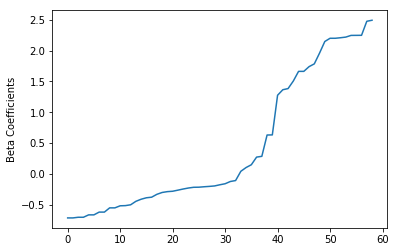

In [71]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

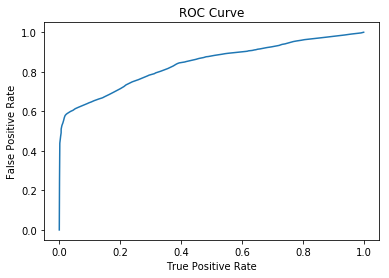

Training set areaUnderROC 0.8410696109512238


In [75]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC {}'.format(trainingSummary.areaUnderROC))

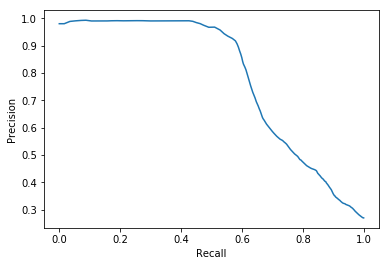

In [77]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'], pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [84]:
predictions = lrModel.transform(test)
predictions.select('primary_type','month','Night?','rawPrediction','Prediction','Arrest1', 'probability').show(10)

+------------+-----+------+--------------------+----------+-------+--------------------+
|primary_type|month|Night?|       rawPrediction|Prediction|Arrest1|         probability|
+------------+-----+------+--------------------+----------+-------+--------------------+
|       THEFT|    7|     0|[2.26379354316854...|       0.0|      0|[0.90583371502653...|
|       THEFT|    6|     0|[2.26341302617074...|       0.0|      0|[0.90580125229603...|
|       THEFT|    2|     0|[2.25458631617842...|       0.0|      0|[0.90504540778828...|
|       THEFT|    7|     0|[2.25783118813362...|       0.0|      0|[0.90532390002813...|
|       THEFT|    6|     0|[2.26061698314043...|       0.0|      0|[0.90556240811763...|
|       THEFT|   10|     0|[2.25671280344530...|       0.0|      0|[0.90522799697657...|
|       THEFT|    9|     0|[2.26279654315894...|       0.0|      0|[0.90574863751025...|
|       THEFT|   11|     0|[2.26257827791209...|       0.0|      0|[0.90573000298302...|
|       THEFT|    4| 

In [87]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print('Test Area Under ROC {}'.format(evaluator.evaluate(predictions)))

Test Area Under ROC 0.841043127803535


In [93]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth=3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('primary_type','month','Night?',\
                   'rawPrediction','Prediction','Arrest1', 'probability').show(10)

+------------+-----+------+-------------------+----------+-------+--------------------+
|primary_type|month|Night?|      rawPrediction|Prediction|Arrest1|         probability|
+------------+-----+------+-------------------+----------+-------+--------------------+
|       THEFT|    7|     0|[946353.0,176830.0]|       0.0|      0|[0.84256350033787...|
|       THEFT|    6|     0|[946353.0,176830.0]|       0.0|      0|[0.84256350033787...|
|       THEFT|    2|     0|[946353.0,176830.0]|       0.0|      0|[0.84256350033787...|
|       THEFT|    7|     0|[946353.0,176830.0]|       0.0|      0|[0.84256350033787...|
|       THEFT|    6|     0|[946353.0,176830.0]|       0.0|      0|[0.84256350033787...|
|       THEFT|   10|     0|[946353.0,176830.0]|       0.0|      0|[0.84256350033787...|
|       THEFT|    9|     0|[946353.0,176830.0]|       0.0|      0|[0.84256350033787...|
|       THEFT|   11|     0|[946353.0,176830.0]|       0.0|      0|[0.84256350033787...|
|       THEFT|    4|     0|[9463

In [94]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print('Test Area Under ROC {}'.format(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC 0.25698903447509486


In [95]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('primary_type','month','Night?',\
                   'rawPrediction','Prediction','Arrest1', 'probability').show(10)

+------------+-----+------+--------------------+----------+-------+--------------------+
|primary_type|month|Night?|       rawPrediction|Prediction|Arrest1|         probability|
+------------+-----+------+--------------------+----------+-------+--------------------+
|       THEFT|    7|     0|[16.9804511273023...|       0.0|      0|[0.84902255636511...|
|       THEFT|    6|     0|[16.9804511273023...|       0.0|      0|[0.84902255636511...|
|       THEFT|    2|     0|[16.9804511273023...|       0.0|      0|[0.84902255636511...|
|       THEFT|    7|     0|[16.9804511273023...|       0.0|      0|[0.84902255636511...|
|       THEFT|    6|     0|[16.9804511273023...|       0.0|      0|[0.84902255636511...|
|       THEFT|   10|     0|[16.9804511273023...|       0.0|      0|[0.84902255636511...|
|       THEFT|    9|     0|[16.9804511273023...|       0.0|      0|[0.84902255636511...|
|       THEFT|   11|     0|[16.9804511273023...|       0.0|      0|[0.84902255636511...|
|       THEFT|    4| 

In [96]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print('Test Area Under ROC {}'.format(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC 0.8253596781777944


In [98]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('primary_type','month','Night?',\
                   'rawPrediction','Prediction','Arrest1', 'probability').show(10)

+------------+-----+------+--------------------+----------+-------+--------------------+
|primary_type|month|Night?|       rawPrediction|Prediction|Arrest1|         probability|
+------------+-----+------+--------------------+----------+-------+--------------------+
|       THEFT|    7|     0|[0.89685435038625...|       0.0|      0|[0.85738137243753...|
|       THEFT|    6|     0|[0.89685435038625...|       0.0|      0|[0.85738137243753...|
|       THEFT|    2|     0|[0.89685435038625...|       0.0|      0|[0.85738137243753...|
|       THEFT|    7|     0|[0.89685435038625...|       0.0|      0|[0.85738137243753...|
|       THEFT|    6|     0|[0.89685435038625...|       0.0|      0|[0.85738137243753...|
|       THEFT|   10|     0|[0.89685435038625...|       0.0|      0|[0.85738137243753...|
|       THEFT|    9|     0|[0.89685435038625...|       0.0|      0|[0.85738137243753...|
|       THEFT|   11|     0|[0.89685435038625...|       0.0|      0|[0.85738137243753...|
|       THEFT|    4| 

In [99]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print('Test Area Under ROC {}'.format(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC 0.8489653698233357
